Play the communication game from visual input

In [1]:
import argparse
import os
import sys
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms

import egg.core as core
from input_image.features import ImageNetFeat, ImagenetLoader
from input_image.train import parse_arguments, loss, loss_nll, get_game

In [2]:
sys.argv = '--root=./data/formatted/image --n_epochs=30 --batch_size=16 \
--lr=0.001 --checkpoint_dir=./save/model'.split(' ')

In [3]:
opts = parse_arguments()

dataset_train = ImageNetFeat(root=os.path.join(opts.root, "./data/formatted/image/train"))
dataset_test = ImageNetFeat(root=os.path.join(opts.root, "./data/formatted/image/test/"))

train_loader = ImagenetLoader(dataset_train, batch_size=opts.batch_size, shuffle=True, opt=opts,
                              batches_per_epoch=opts.batches_per_epoch, seed=None)
validation_loader = ImagenetLoader(dataset_test, opt=opts, batch_size=opts.batch_size,
                                   batches_per_epoch=opts.batches_per_epoch,
                                   seed=7)

In [4]:
game = get_game(opts)
optimizer = core.build_optimizer(game.parameters())
callback = None
if opts.mode == 'gs':
    callbacks = [core.TemperatureUpdater(
        agent=game.sender, decay=0.9, minimum=0.1)]
else:
    callbacks = []

callbacks.append(core.ConsoleLogger(as_json=True, print_train_loss=True))
trainer = core.Trainer(game=game, optimizer=optimizer, train_data=train_loader,
                       validation_data=validation_loader, callbacks=callbacks)

In [5]:
%%capture cap --no-stderr
trainer.train(n_epochs=opts.n_epochs)

In [6]:
def plot_result(result_df, mode):
    fig,ax = plt.subplots()
    for col in ['acc','sender_entropy','receiver_entropy']:
        ax.plot(result_df[result_df['mode'] == mode]['epoch'],
                result_df[result_df['mode'] == mode][col],
                label=col)

    ax.set_xlabel("epoch")
    # ax.set_ylabel("weight")
    ax.legend(loc='best')

In [7]:
result_df = pd.DataFrame([json.loads(line) for line in cap.stdout.split('\n') if line])

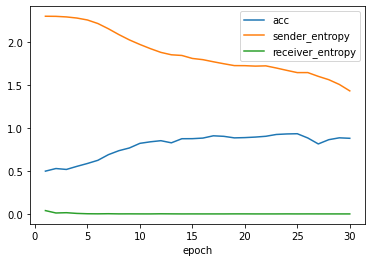

In [8]:
plot_result(result_df, 'train')

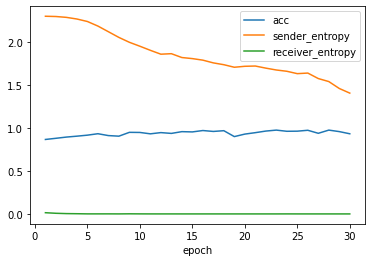

In [9]:
plot_result(result_df, 'test')

In [5]:
trainer.load_from_checkpoint('./save/model/final.tar')

# loading trainer state from ./save/model/final.tar


In [6]:
net = trainer.game.sender.agent
# net = net.eval()
net

InformedSender(
  (lin1): Linear(in_features=64, out_features=50, bias=False)
  (conv2): Conv2d(1, 20, kernel_size=(2, 1), stride=(2, 1), bias=False)
  (conv3): Conv2d(1, 1, kernel_size=(20, 1), stride=(20, 1), bias=False)
  (lin4): Linear(in_features=50, out_features=10, bias=False)
  (conv1_): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool_): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1_): Linear(in_features=400, out_features=120, bias=True)
  (fc2_): Linear(in_features=120, out_features=64, bias=True)
)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
trainset = torchvision.datasets.CIFAR10(root='./data/original/image', train=True,
                                        download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=False, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data/original/image', train=False,
                                       download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

net.fc2_.register_forward_hook(get_activation('fc2_'))

features, labels = [], []
for data in trainloader:
    images, label = data
    images = images.to(device)
    net(images)
    features.append(activation['fc2_'].cpu().detach().numpy())
    labels.append(label.numpy())
features = np.concatenate(features)
labels = np.concatenate(labels)

In [13]:
features = F.relu(torch.from_numpy(features)).numpy()

In [14]:
np.save('./save/feature/train_relu.npy', features)
np.save('./save/feature/train_labels.npy', labels)

In [15]:
features[0]

array([  0.      ,   0.      , 337.1321  ,   0.      ,   0.      ,
       287.1298  , 345.9167  ,   0.      ,   0.      ,   0.      ,
       313.0795  ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      , 152.23413 , 208.22241 ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
        85.644966,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,  81.235664,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      , 224.86362 ,   0.      ,
         0.      ,   0.      ,   0.      , 323.8168  ,   0.      ,
         0.      , 146.46732 ,   0.      ,   0.      ], dtype=float32)